# Stance Detection

In [5]:
import torch
import pandas as pd
import nltk
import numpy as np
import preprocessing, feature_engineering, helpers
import importlib
from collections import Counter
from sklearn.metrics import confusion_matrix
import score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import scipy
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import time
import itertools
import utils
import importlib

/Users/dannyyang/Library/Python/3.6/lib/python/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [6]:
importlib.reload(preprocessing)
importlib.reload(feature_engineering)
importlib.reload(helpers)
importlib.reload(utils)
preprocess = preprocessing.Preprocessing()

In [7]:
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

In [8]:
train_stances = pd.read_csv("fn_data/train_stances.csv")
train_stances = train_stances.loc[lambda x: x.Stance != "unrelated"]
print(train_stances.shape)
train_stances.head()

(13427, 3)


,Headline,Body ID,Stance
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
4,Spider burrowed through tourist's stomach and ...,1923,disagree
5,'Nasa Confirms Earth Will Experience 6 Days of...,154,agree
8,Banksy 'Arrested & Real Identity Revealed' Is ...,1739,agree
10,Gateway Pundit,2327,discuss


In [9]:
train_bodies = pd.read_csv("fn_data/train_bodies.csv")
print(train_bodies.shape)
train_bodies.head()

(1683, 2)


,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...


In [10]:
stances_tr, stances_val = preprocess.train_test_split(train_bodies, train_stances)
stances_tr.shape, stances_val.shape

((10726, 3), (2701, 3))

In [11]:
ct = Counter(stances_val['Stance'])
print(ct)
print(ct.most_common(1)[0][1]/len(list(stances_val["Stance"])))

Counter({'discuss': 1715, 'agree': 798, 'disagree': 188})
0.6349500185116623


In [68]:
def process_word_stance(word, glove_dict):
    #50d word vector
    if word in glove_dict:
        wv = glove_dict[word]
    else:
        wv = np.zeros((50, ))
    #4d sentiment
    sent = preprocess.get_sentiment(word)
    #36d one-hot encoding of part of speech
    pos = nltk.pos_tag(word)[1]
    pos_encoding = [(1 if tag == pos else 0) for tag in preprocess.pos_tags]
    #boolean flag for negating word
    stemmed_word = preprocess.stem_word(word)
    is_neg = (1 if stemmed_word in preprocess.negating_words_stemmed else 0)
    is_refuting = (1 if stemmed_word in preprocess.refuting_words_stemmed else 0)
    embedding = np.concatenate([wv, [sent["pos"], sent["neg"], sent["neu"], sent["compound"], is_neg, is_refuting], pos_encoding])
    return embedding

def process_text_stance(text, glove_dict, n_words = 25):
    tokens = preprocess.get_clean_tokens(text, False)
    if len(tokens)>=n_words:
        tokens = tokens[:n_words]
        encoding = np.array([process_word_stance(token, glove_dict) for token in tokens])
    elif len(tokens)<n_words:
        padding = [np.zeros((92,))]*(n_words-len(tokens))
        encoding = np.array([process_word_stance(token, glove_dict) for token in tokens]+padding)
    return encoding

def process_bodies_stance(df, glove_dict):
    body_info = {}
    ids = list(df["Body ID"])
    for i in range(len(ids)):
        if i % 100 == 0 and i != 0:
            print("processed "+str(i))
        body_info[ids[i]] = process_text_stance(preprocess.get_body(ids[i],df), glove_dict, 50)
    print("done! processed " + str(len(ids)))
    return body_info

def process_feats_stance(data, body_dict, glove_dict):
    headline, body_id = data[0], int(data[1])
    padding = [np.zeros((92,))] #1 word of padding
    return np.concatenate([process_text_stance(headline, glove_dict), np.array(padding), body_dict[body_id]])

In [69]:
body_dict = process_bodies_stance(train_bodies, glove_dict)

processed 100
processed 200
processed 300
processed 400
processed 500
processed 600
processed 700
processed 800
processed 900
processed 1000
processed 1100
processed 1200
processed 1300
processed 1400
processed 1500
processed 1600
done! processed 1683


In [70]:
start = time.time()
train_feats = [process_feats_stance(i, body_dict, glove_dict) for i in stances_tr.values]
val_feats = [process_feats_stance(i, body_dict, glove_dict) for i in stances_val.values]
end = time.time()
print(int(end-start))

75


In [71]:
# To do: get the new get batch function
def get_batch(data, targets, i,batch_size):
    batches = data[i*batch_size:i*batch_size+batch_size]
    results = targets[i*batch_size:i*batch_size+batch_size]
    results = [(2 if result == "agree" else (1 if result == "discuss" else 0)) for result in results]
    return np.array(batches),np.array(results)

In [72]:
# Test the Model
def eval_model(model):
    correct = 0
    total = 0
    batch_x_test,batch_y_test = get_batch(val_feats,[str(x[-1]) for x in stances_val.values],0,len(stances_val))
    model.eval()
    predicted = None
    with torch.no_grad():
        inputs = Variable(torch.FloatTensor(batch_x_test))
        labels = torch.LongTensor(batch_y_test)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    print('Accuracy: %d %%' % (100 * correct / total))
    return predicted

In [73]:
def score_model(predictions):    
    #use FNC scorer to generate score report
    label_prediction = [("agree" if x == 2 else ("discuss" if x == 1 else "disagree")) for x in predictions]
    label_actual = pd.DataFrame(stances_val)['Stance']
    matrix = confusion_matrix(label_actual,label_prediction)
    print('confusion matrix: \n{}\n'.format(matrix))
    score.report_score(label_actual, label_prediction)
    return matrix

In [74]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8

"""
    correct = (preds == y).float() #convert into float for division 
    acc = correct.sum()/len(correct)
    return acc

In [75]:
class Siamese(nn.Module):
    # hidden dim: dimension of one RNN
    # 2 * hidden dim: concatenated outputs
    def __init__(self,embedding_dim, hidden_dim_head, hidden_dim_bod, dropout, output_dim):
        super().__init__()
        
        # RNN dimensions [embedding_dim, hidden_dim]
        # To-Do: try varying hidden, output dims for each network
        self.rnn1 = nn.RNN(20, hidden_dim_head, dropout=dropout)
        self.rnn2 = nn.RNN(72, hidden_dim_bod, dropout=dropout)
        # Note: output dim could technically be higher now? cause runnign through a loss function/MLP
        #self.fc1 = nn.Linear(hidden_dim, output_dim)
        #self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.fc = nn.Linear(hidden_dim_head+hidden_dim_bod, output_dim)
        
        
    def forward(self, x):
        # x originally = [batch size, nubmer of words, embedding dim]
        # swap first two dimensions to match rnn specs
        #print(f'x shape before: ${x.shape}')
        x = x.permute([1,0,2])
        
        #print(f'x shape: ${x.shape}')
        header = x[:, :, :20]
        article = x[:, :, 20:]
        
        #print(f'header shape: ${header.shape}')
        #print(f'article shape: ${article.shape}')
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        output1, hidden1 = self.rnn1(header)
        output2, hidden2 = self.rnn2(article)
        #print(f'Hidden1 shape: {hidden1.squeeze(0).shape}')
        #print(f'Hidden2 shape: {hidden2.squeeze(0).shape}')
     
        hidden = self.dropout(torch.cat((hidden1.squeeze(0), hidden2.squeeze(0)),1))
        #print(f'Hidden shape: {hidden.shape}')

        #out = self.fc1(hidden1.squeeze(0))
        #out = out.append(self.fc2(hidden2.squeeze(0)))
        
        return self.fc(hidden)

In [82]:
# To do: re-implement with LSTMs for each branch
class Siamese_LSTM(nn.Module):
    # hidden dim: dimension of one RNN
    # 2 * hidden dim: concatenated outputs
    def __init__(self, hidden_dim_head, hidden_dim_bod, 
                 n_layers_head, n_layers_bod, dropout, output_dim):
        super().__init__()
        
        # RNN dimensions [embedding_dim, hidden_dim]
        # To-Do: try varying hidden, output dims for each network
        
        self.rnn1 = nn.LSTM(92, hidden_dim_head, num_layers=n_layers_head, bidirectional=True, dropout=dropout)
        self.rnn2 = nn.LSTM(92, hidden_dim_bod, num_layers=n_layers_bod, bidirectional=True, dropout=dropout)
        # Note: output dim could technically be higher now? cause runnign through a loss function/MLP
       
        self.dropout = nn.Dropout(dropout)
        
        self.fc1 = nn.Linear((hidden_dim_head+hidden_dim_bod)*2, (hidden_dim_head+hidden_dim_bod)) #doubled for bidirectional
        self.fc2 = nn.Linear((hidden_dim_head+hidden_dim_bod), output_dim)
        
    def set_n_layers(self, head, bod):
        self.rnn1.num_layers = head
        self.rnn2.num_layers = bod
        
    def set_n_hidden(self, head, bod):
        self.rnn1.hidden_size = head
        self.rnn2.hidden_size = bod
        
    def set_dropout(self, droupout):
        self.droupout = droupout
        
    def forward(self, x):
        # x originally = [batch size, nubmer of words, embedding dim]
        # swap first two dimensions to match rnn specs
        #print(f'x shape before: ${x.shape}')
        x = x.permute([1,0,2])
        
        #print(f'x shape: ${x.shape}')
        header = x[:20, :, :]
        article = x[20:, :, :]
        
        #print(f'header shape: ${header.shape}')
        #print(f'article shape: ${article.shape}')
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        output1, (hidden1, cell1) = self.rnn1(header)
        output2, (hidden2, cell2) = self.rnn2(article)
        
        """print(f'Hidden1 shape: {hidden1.squeeze(0).shape}')
        print(f'Hidden2 shape: {hidden2.squeeze(0).shape}')"""
        
        # Concats the last forward and backward hidden layers
        # Wouldn't you only technically want to do this if it is in fact bidirectional? 
        hidden = torch.cat((hidden1[-2,:,:], hidden1[-1,:,:], hidden2[-2,:,:], hidden2[-1,:,:]), dim=1)

        """print(f'Hidden1 shape front/back: {hidden1.shape}')
        print(f'Hidden2 shape front/back: {hidden2.shape}')"""
        # TODO: Check if concatenating along dim 1 might be better if first squeeze each hidden
        """print(f'Concatenated shape: {hidden_merge.shape}')"""
     
        hidden = self.dropout(hidden)
        
        # Todo: add more layers beforehand, that's way too many to concatenate down to 3
        fc1 = self.fc1(hidden)
        """print(f'FC shape: {fc1.shape}')"""
        fc1 = F.relu(fc1)
        fc2 = self.fc2(fc1)
        return fc2

In [83]:
HIDDEN_DIM_HEAD = 128
HIDDEN_DIM_BOD = 128

OUTPUT_DIM = 3
num_epochs = 5
batch_size = 500
display_step = 1

N_LAYERS = 2
#BIDIRECTIONAL = True
DROPOUT = 0.5

In [88]:
model = Siamese_LSTM(hidden_dim_head=HIDDEN_DIM_HEAD, hidden_dim_bod=HIDDEN_DIM_BOD, 
                dropout=DROPOUT, output_dim=OUTPUT_DIM, n_layers_head=1, n_layers_bod=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# model1 = Siamese_LSTM(hidden_dim_head=HIDDEN_DIM_HEAD, hidden_dim_bod=HIDDEN_DIM_BOD, 
#                 dropout=DROPOUT, output_dim=OUTPUT_DIM, n_layers_head=2, n_layers_bod=3)
# optimizer1 = torch.optim.Adam(model1.parameters(), lr=1e-4, weight_decay=1e-5)

# # Plateaus at 69.7 validation, some decrease in loss but not enough
# model2 = Siamese_LSTM(hidden_dim_head=250, hidden_dim_bod=250, 
#                 dropout=DROPOUT, output_dim=OUTPUT_DIM, n_layers_head=2, n_layers_bod=2)
# optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-4, weight_decay=1e-5)

# model3 = Siamese_LSTM(hidden_dim_head=100, hidden_dim_bod=100, 
#                 dropout=DROPOUT, output_dim=OUTPUT_DIM, n_layers_head=2, n_layers_bod=2)
# optimizer3 = torch.optim.Adam(model3.parameters(), lr=1e-4, weight_decay=1e-5)

# model4 = Siamese_LSTM(hidden_dim_head=HIDDEN_DIM_HEAD, hidden_dim_bod=HIDDEN_DIM_BOD, 
#                 dropout=0.3, output_dim=OUTPUT_DIM, n_layers_head=2, n_layers_bod=2)
# optimizer4 = torch.optim.Adam(model4.parameters(), lr=1e-4, weight_decay=1e-5)

criterion = nn.CrossEntropyLoss()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [89]:
queue = [(model, optimizer)] #,(model2,optimizer2),(model3,optimizer3),(model4,optimizer4)]

In [90]:
def train(model, total_batch, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for i in range(total_batch):
        batch_x,batch_y = get_batch(train_feats, [str(x[-1]) for x in stances_tr.values],i,batch_size)
        inputs = Variable(torch.FloatTensor(batch_x))
        labels = Variable(torch.LongTensor(batch_y))
        
        optimizer.zero_grad()
        predictions = model(inputs)
        loss = criterion(predictions, labels)
        _, predicted = torch.max(predictions.data, 1)
        acc = binary_accuracy(predicted, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / total_batch, epoch_acc / total_batch

def evaluate(model, total_batch, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for i in range(total_batch):
            batch_x,batch_y = get_batch(val_feats, [str(x[-1]) for x in stances_val.values],i,batch_size)
            inputs = Variable(torch.FloatTensor(batch_x))
            labels = Variable(torch.LongTensor(batch_y))
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            _, predicted = torch.max(predictions.data, 1)
            acc = binary_accuracy(predicted, labels)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / total_batch, epoch_acc / total_batch

In [91]:
batches_train= int(len(train_feats)/batch_size)
batches_val = int(len(val_feats)/batch_size)
    

for i in range(len(queue)):
    start = time.time()
    model = queue[i][0]
    optimizer = queue[i][1]
    print(f'model {i}')
    
    for epoch in range(num_epochs):

        train_loss, train_acc = train(model, batches_train, optimizer, criterion)
        valid_loss, valid_acc = evaluate(model, batches_val, criterion)

        print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')
    print(int(time.time()-start))
    baseline_tr = Counter(stances_tr['Stance']).most_common(1)[0][1]/len(list(stances_tr["Stance"]))
    baseline_val = Counter(stances_val['Stance']).most_common(1)[0][1]/len(list(stances_val["Stance"]))
    print(f'Baseline Train = {baseline_tr:.2f}%, Test = {baseline_val:.2f}%')

model 0
| Epoch: 01 | Train Loss: 1.072 | Train Acc: 67.04% | Val. Loss: 1.074 | Val. Acc: 63.04% |
| Epoch: 02 | Train Loss: 1.062 | Train Acc: 67.13% | Val. Loss: 1.065 | Val. Acc: 63.04% |
| Epoch: 03 | Train Loss: 1.052 | Train Acc: 67.13% | Val. Loss: 1.056 | Val. Acc: 63.04% |
| Epoch: 04 | Train Loss: 1.042 | Train Acc: 67.13% | Val. Loss: 1.046 | Val. Acc: 63.04% |
| Epoch: 05 | Train Loss: 1.030 | Train Acc: 67.13% | Val. Loss: 1.036 | Val. Acc: 63.04% |
173
Baseline Train = 0.67%, Test = 0.63%


In [28]:
# Test the Model
predicted = eval_model(model)

Accuracy: 63 %


In [29]:
predicted_l = [i.item() for i in list(predicted)]
Counter(predicted_l)

Counter({1: 2701})

confusion matrix: 
[[   0    0  798]
 [   0    0  188]
 [   0    0 1715]]

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |     0     |     0     |    798    |     0     |
-------------------------------------------------------------
| disagree  |     0     |     0     |    188    |     0     |
-------------------------------------------------------------
|  discuss  |     0     |     0     |   1715    |     0     |
-------------------------------------------------------------
| unrelated |     0     |     0     |     0     |     0     |
-------------------------------------------------------------
Score: 1961.5 out of 2701.0	(72.62125138837467%)
Normalized confusion matrix
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


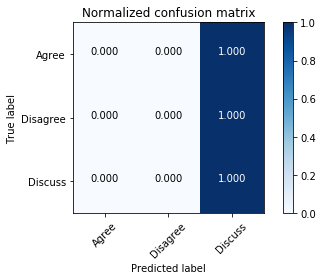

In [30]:
matrix = score_model(predicted_l)
utils.plot_confusion_matrix(matrix, classes=["Agree","Disagree", "Discuss"],
                      title='Normalized confusion matrix')
plt.show();

In [31]:
true_label = [(2 if x[-1] == "agree" else (1 if x[-1] == "discuss" else 0)) for x in stances_val.values]
[list(x) for x in list(confusion_matrix(true_label,predicted_l))]

[[0, 188, 0], [0, 1715, 0], [0, 798, 0]]

# train finalized model below

In [99]:
model_final = CNN(EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)

In [122]:
fts = train_feats+val_feats
tr_labels = [str(x[-1]) for x in stances_tr.values]+[str(x[-1]) for x in stances_val.values]

def train_final(model, total_batch, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model_final.train()
    for i in range(total_batch):
        batch_x,batch_y = get_batch(fts, tr_labels,i,batch_size)
        inputs = Variable(torch.FloatTensor(batch_x))
        labels = Variable(torch.LongTensor(batch_y))
        
        optimizer.zero_grad()
        predictions = model_final(inputs)
        loss = criterion(predictions, labels)
        _, predicted = torch.max(predictions.data, 1)
        acc = binary_accuracy(predicted, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / total_batch, epoch_acc / total_batch

In [104]:
batches_train= int(len(fts)/batch_size)

for epoch in range(num_epochs):
    train_loss, train_acc = train_final(model_f, batches_train, optimizer, criterion)
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% |')

| Epoch: 01 | Train Loss: 0.727 | Train Acc: 69.69% |
| Epoch: 02 | Train Loss: 0.555 | Train Acc: 77.40% |
| Epoch: 03 | Train Loss: 0.465 | Train Acc: 80.90% |


In [105]:
torch.save(model_final.state_dict(), './Siamese.pth')